# Virtual Concierge

## Compile Pretrained MXNET model with NEO

In this notebook we will download a pre-trained MXNET model and compile for `ml_m4` and `deeplens` targets.

In [1]:
# Download pre-trained model if haven't already created from previous notebook
import os

if not os.path.exists('model.tar.gz'):
    !aws s3 cp s3://deeplens-virtual-concierge-model/mobilefacenet/model.tar.gz .

## Invoke Neo Compilation API

We then forward the model artifact to Neo Compilation API:

In [2]:
import boto3
import sagemaker
import time
from sagemaker.utils import name_from_base

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()

compilation_job_name = name_from_base('virtual-concierge')

model_key = '{}/model/model.tar.gz'.format(compilation_job_name)
model_path = 's3://{}/{}'.format(bucket, model_key)
boto3.resource('s3').Bucket(bucket).upload_file('model.tar.gz', model_key)

sm_client = boto3.client('sagemaker')
data_shape = '{"data":[1,3,112,112]}'
target_device = 'ml_m4'
framework = 'MXNET'
framework_version = '1.2'
compiled_model_path = 's3://{}/{}/output'.format(bucket, compilation_job_name)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-423079281568


In [3]:
response = sm_client.create_compilation_job(
    CompilationJobName=compilation_job_name,
    RoleArn=role,
    InputConfig={
        'S3Uri': model_path,
        'DataInputConfig': data_shape,
        'Framework': framework
    },
    OutputConfig={
        'S3OutputLocation': compiled_model_path,
        'TargetDevice': target_device
    },
    StoppingCondition={
        'MaxRuntimeInSeconds': 300
    }
)
print(response)

# Poll every 30 sec
while True:
    response = sm_client.describe_compilation_job(CompilationJobName=compilation_job_name)
    if response['CompilationJobStatus'] == 'COMPLETED':
        break
    elif response['CompilationJobStatus'] == 'FAILED':
        raise RuntimeError('Compilation failed')
    print('Compiling ...')
    time.sleep(30)
print('Done!')

# Extract compiled model artifact
compiled_model_path = response['ModelArtifacts']['S3ModelArtifacts']

{'CompilationJobArn': 'arn:aws:sagemaker:us-east-1:423079281568:compilation-job/virtual-concierge-2019-04-01-08-08-08-410', 'ResponseMetadata': {'RequestId': '792a2134-8934-46b1-a27b-d6e3dbd33402', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '792a2134-8934-46b1-a27b-d6e3dbd33402', 'content-type': 'application/x-amz-json-1.1', 'content-length': '122', 'date': 'Mon, 01 Apr 2019 08:08:08 GMT'}, 'RetryAttempts': 0}}
Compiling ...
Done!


## Create prediction endpoint

To create a prediction endpoint, we first specify two additional functions, to be used with Neo Deep Learning Runtime:

* `neo_preprocess(payload, content_type)`: Function that takes in the payload and Content-Type of each incoming request and returns a NumPy array. Here, the payload is byte-encoded NumPy array, so the function simply decodes the bytes to obtain the NumPy array.
* `neo_postprocess(result)`: Function that takes the prediction results produced by Deep Learining Runtime and returns the response body

In [4]:
!pygmentize predict.py

def transform_fn(model, request_body, request_content_type, accept_type):
    """
    Transform a request using the Gluon model. Called once per request.
    :param model: The model.
    :param request_body: The request payload.
    :param request_content_type: The request content type.
    :param accept_type: The (desired) response content type.
    :return: response payload and content type.
    """

    import mxnet as mx
    import logging
    
    logging.info('Invoking transform Shape: {}, Content Type: {}, Accept: {}'.format(
        model.data_shapes[0][1], request_content_type, accept_type))
    
    array = neo_preprocess(request_body, request_content_type)
    
    print('input', array)

    data = mx.nd.array(array)
    db = mx.io.DataBatch(data=(data,))
    model.forward(db, is_train=False)
    output = model.get_outputs()[0].asnumpy()
    
    print('output', output)

    if accept_type == 'application/json':
        return neo_postprocess(output)
    else:
        raise 

Upload the Python script containing the two functions to S3:

In [5]:
import tarfile

source_key = '{}/source/sourcedir.tar.gz'.format(compilation_job_name)
source_path = 's3://{}/{}'.format(bucket, source_key)

with tarfile.open('sourcedir.tar.gz', 'w:gz') as f:
    f.add('predict.py')

boto3.resource('s3').Bucket(bucket).upload_file('sourcedir.tar.gz', source_key)

We then create a SageMaker model record:

In [6]:
from sagemaker.model import NEO_IMAGE_ACCOUNT
from sagemaker.fw_utils import create_image_uri

model_name = name_from_base('virtual-concierge') + target_device.replace('_', '-')

image_uri = create_image_uri(region, 'neo-' + framework.lower(), target_device.replace('_', '.'),
                             framework_version, py_version='py3', account=NEO_IMAGE_ACCOUNT[region])

response = sm_client.create_model(
    ModelName=model_name,
    PrimaryContainer={
        'Image': image_uri,
        'ModelDataUrl': compiled_model_path,
        'Environment': { 'SAGEMAKER_SUBMIT_DIRECTORY': source_path }
    },
    ExecutionRoleArn=role
)
print(response)

{'ModelArn': 'arn:aws:sagemaker:us-east-1:423079281568:model/virtual-concierge-2019-04-01-08-08-40-420ml-m4', 'ResponseMetadata': {'RequestId': '89ce4c8e-781a-4630-809c-1ab1caef9bf0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '89ce4c8e-781a-4630-809c-1ab1caef9bf0', 'content-type': 'application/x-amz-json-1.1', 'content-length': '108', 'date': 'Mon, 01 Apr 2019 08:08:40 GMT'}, 'RetryAttempts': 0}}


Then we create an Endpoint Configuration:

In [7]:
config_name = model_name

response = sm_client.create_endpoint_config(
    EndpointConfigName=config_name,
    ProductionVariants=[
        {
            'VariantName': 'default-variant-name',
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.m4.xlarge',
            'InitialVariantWeight': 1.0
        },
    ],
)
print(response)

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:423079281568:endpoint-config/virtual-concierge-2019-04-01-08-08-40-420ml-m4', 'ResponseMetadata': {'RequestId': '0bda4b90-7bee-4013-935b-c5f13a977527', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '0bda4b90-7bee-4013-935b-c5f13a977527', 'content-type': 'application/x-amz-json-1.1', 'content-length': '127', 'date': 'Mon, 01 Apr 2019 08:08:40 GMT'}, 'RetryAttempts': 0}}


Finally, we create an Endpoint:

In [8]:
endpoint_name = model_name

response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=config_name,
)
print(response)

print('Creating endpoint ...')
sm_client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

response = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(response)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:423079281568:endpoint/virtual-concierge-2019-04-01-08-08-40-420ml-m4', 'ResponseMetadata': {'RequestId': '461608ef-a9eb-4506-a78c-b84a0a598d8a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '461608ef-a9eb-4506-a78c-b84a0a598d8a', 'content-type': 'application/x-amz-json-1.1', 'content-length': '114', 'date': 'Mon, 01 Apr 2019 08:08:41 GMT'}, 'RetryAttempts': 0}}
Creating endpoint ...
{'EndpointName': 'virtual-concierge-2019-04-01-08-08-40-420ml-m4', 'EndpointArn': 'arn:aws:sagemaker:us-east-1:423079281568:endpoint/virtual-concierge-2019-04-01-08-08-40-420ml-m4', 'EndpointConfigName': 'virtual-concierge-2019-04-01-08-08-40-420ml-m4', 'ProductionVariants': [{'VariantName': 'default-variant-name', 'DeployedImages': [{'SpecifiedImage': '785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-neo-mxnet:1.2-cpu-py3', 'ResolvedImage': '785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-neo-mxnet@sha256:3e228fd01ebad4e4a78469907109ac

## Send requests

Download a sample picture, detect the first face

In [9]:
import boto3
import json
import base64
import io
import PIL.Image

s3 = boto3.resource('s3')

# Read image from s3
image = {
    'S3Object': {
        'Bucket': 'aiml-lab-sagemaker',
        'Name': 'politicians/politicians2.jpg'
    }
}

image_object = s3.Object(image['S3Object']['Bucket'] , image['S3Object']['Name'])
payload = image_object.get()['Body'].read()

rekognition = boto3.client('rekognition')
    
# Call rekognition to get bbox
ret = rekognition.detect_faces(
    Image={
        'Bytes': payload
    },
    Attributes=['DEFAULT'],
)

print(ret['FaceDetails'][0]['BoundingBox'])

{'Width': 0.18016082048416138, 'Height': 0.47210270166397095, 'Left': 0.7550099492073059, 'Top': 0.01802222989499569}


Crop the image at the bounding box, resize and convert to bytes read for inference

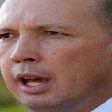

In [10]:
def crop_image(payload, bbox, image_size=(112, 112)):
    f = io.BytesIO(payload)
    # Load image and convert to RGB space
    image = PIL.Image.open(f).convert('RGB')
    # Crop relative to image size
    if bbox != None:
        width, height = image.size
        x1 = int(bbox['Left'] * width)
        y1 = int(bbox['Top'] * height)
        x2 = int(bbox['Left'] * width + bbox['Width'] * width)
        y2 = int(bbox['Top'] * height + bbox['Height']  * height)
        image = image.crop((x1, y1, x2, y2))
    # Resize
    return image.resize(image_size)

# Get a croped image from bytes
image = crop_image(payload, ret['FaceDetails'][0]['BoundingBox'])

# Convert the resized image to bytes
imageBytes = io.BytesIO()
image.save(imageBytes, format='PNG')
payload = imageBytes.getvalue()

image

Send the payload to the endpoint, and output the face embedding response

In [11]:
%%time

import json

sm_runtime = boto3.Session().client('sagemaker-runtime')

response = sm_runtime.invoke_endpoint(EndpointName=endpoint_name,
                                      ContentType='application/x-image',
                                      Body=payload)
print(response)

{'ResponseMetadata': {'RequestId': '03198041-9846-4335-a28c-80510651e53f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '03198041-9846-4335-a28c-80510651e53f', 'x-amzn-invoked-production-variant': 'default-variant-name', 'date': 'Mon, 1 Apr 2019 08:16:14 GMT', 'content-type': 'application/json', 'content-length': '2787'}, 'RetryAttempts': 0}, 'ContentType': 'application/json', 'InvokedProductionVariant': 'default-variant-name', 'Body': <botocore.response.StreamingBody object at 0x7f04249a0080>}
CPU times: user 41.3 ms, sys: 638 µs, total: 41.9 ms
Wall time: 336 ms


In [12]:
np.array(json.loads(response['Body'].read().decode()))

array([-0.10193264, -0.0355223 ,  0.0685785 ,  0.05834587,  0.00922863,
        0.03124793, -0.12483253,  0.09233699,  0.0987841 , -0.05927876,
        0.01801071, -0.11959849,  0.0927461 , -0.06942147, -0.00197528,
        0.0202881 , -0.08490317,  0.10733659, -0.09614307, -0.05989674,
       -0.02829561,  0.02968897, -0.09313127,  0.08862512, -0.05899992,
        0.07426082,  0.00395687,  0.04781275,  0.02246614, -0.06676959,
       -0.04003995,  0.09557328, -0.00730864,  0.12589557, -0.02735926,
       -0.00062963, -0.12004433,  0.07385928,  0.04258921,  0.04088303,
       -0.05689303,  0.09575468, -0.03254858, -0.15459359,  0.15201923,
       -0.11920069,  0.13867068,  0.16915099, -0.03482541, -0.12513849,
        0.0399801 ,  0.0422616 , -0.14761107, -0.10245699, -0.17846349,
       -0.04661909, -0.03152165, -0.07420076, -0.02304682, -0.0235658 ,
        0.03670304,  0.04718212,  0.04580144, -0.00510423, -0.00868418,
        0.09782816, -0.00272855, -0.0172601 , -0.08294388,  0.06

## Clean up

Tear down the Neo endpoint, configuration and model

In [13]:
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '24821821-0187-483f-aaea-875acd2141fe',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '24821821-0187-483f-aaea-875acd2141fe',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 01 Apr 2019 08:16:13 GMT'},
  'RetryAttempts': 0}}

In [14]:
sm_client.delete_endpoint_config(EndpointConfigName=config_name)

{'ResponseMetadata': {'RequestId': 'cff53739-4f1b-4398-922a-1d68b86a422e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'cff53739-4f1b-4398-922a-1d68b86a422e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 01 Apr 2019 08:16:13 GMT'},
  'RetryAttempts': 0}}

In [15]:
sm_client.delete_model(ModelName=model_name)

{'ResponseMetadata': {'RequestId': 'ae6e41a0-72e2-45c1-81ad-1a1e4781b315',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ae6e41a0-72e2-45c1-81ad-1a1e4781b315',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 01 Apr 2019 08:16:13 GMT'},
  'RetryAttempts': 0}}